In [1]:
from pathlib import Path
from typing import Callable

from pysr import PySRRegressor

# pysr before others, since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'postfix', 'disable', 'write_bytes', 'ascii', 'desc', 'unit_divisor', 'smoothing', 'colour', 'file', 'leave', 'nrows', 'iterable', 'initial', 'mininterval', 'unit', 'maxinterval', 'bar_format', 'delay', 'total', 'self', 'gui', 'lock_args', 'position', 'unit_scale', 'miniters', 'dynamic_ncols', 'ncols'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


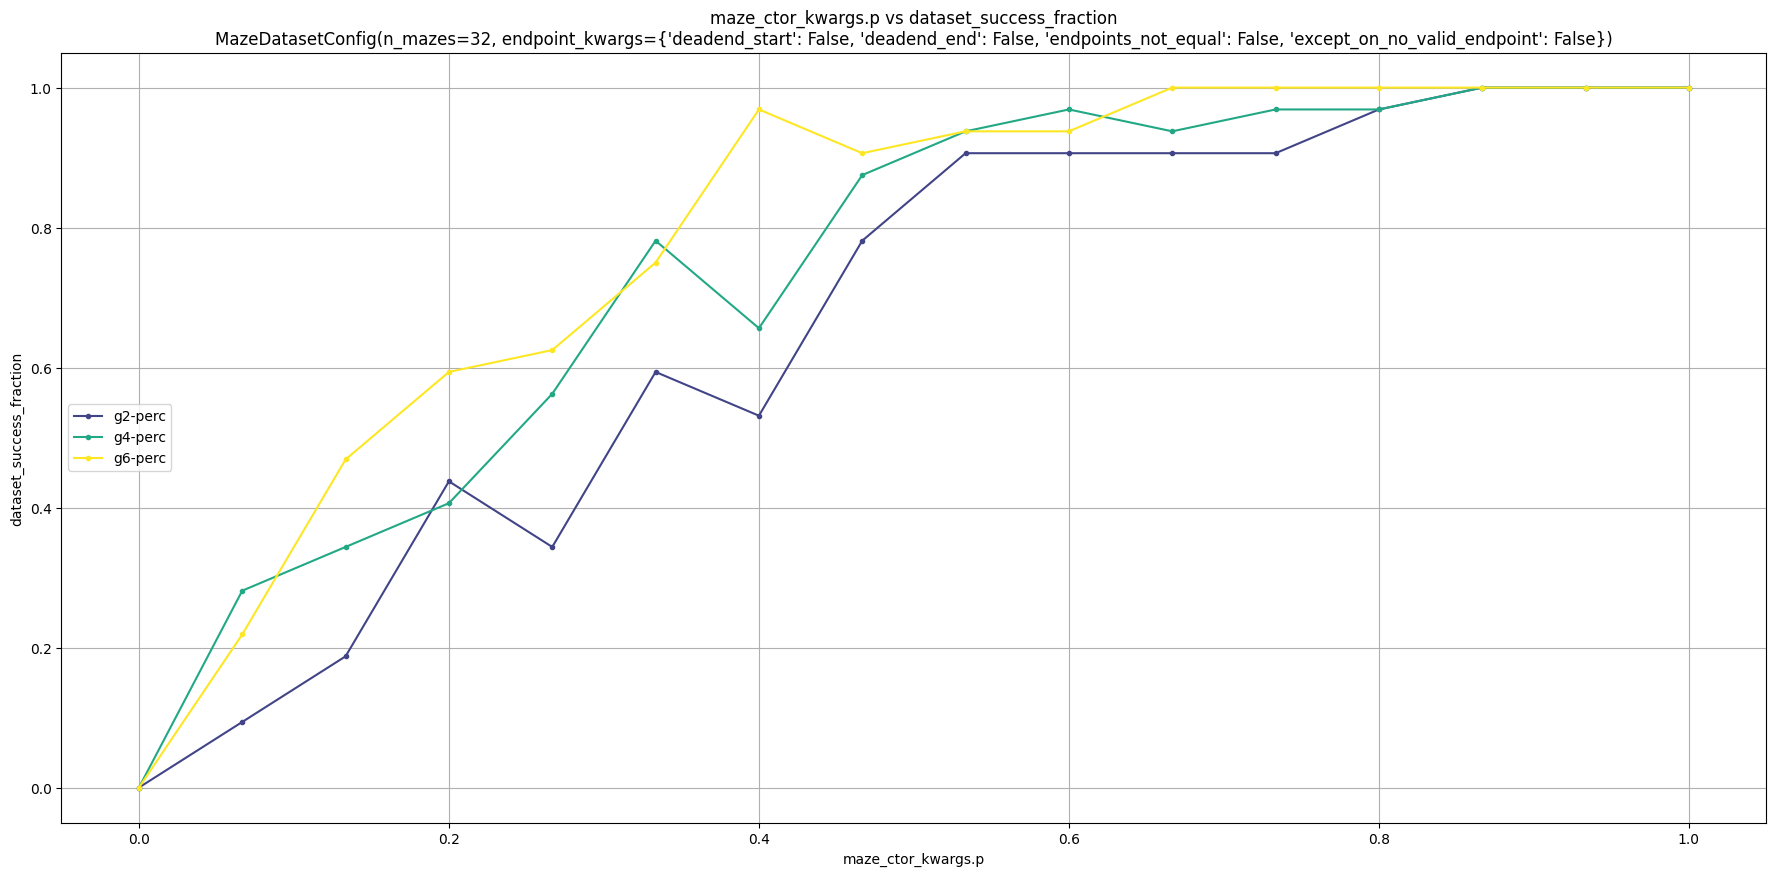

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

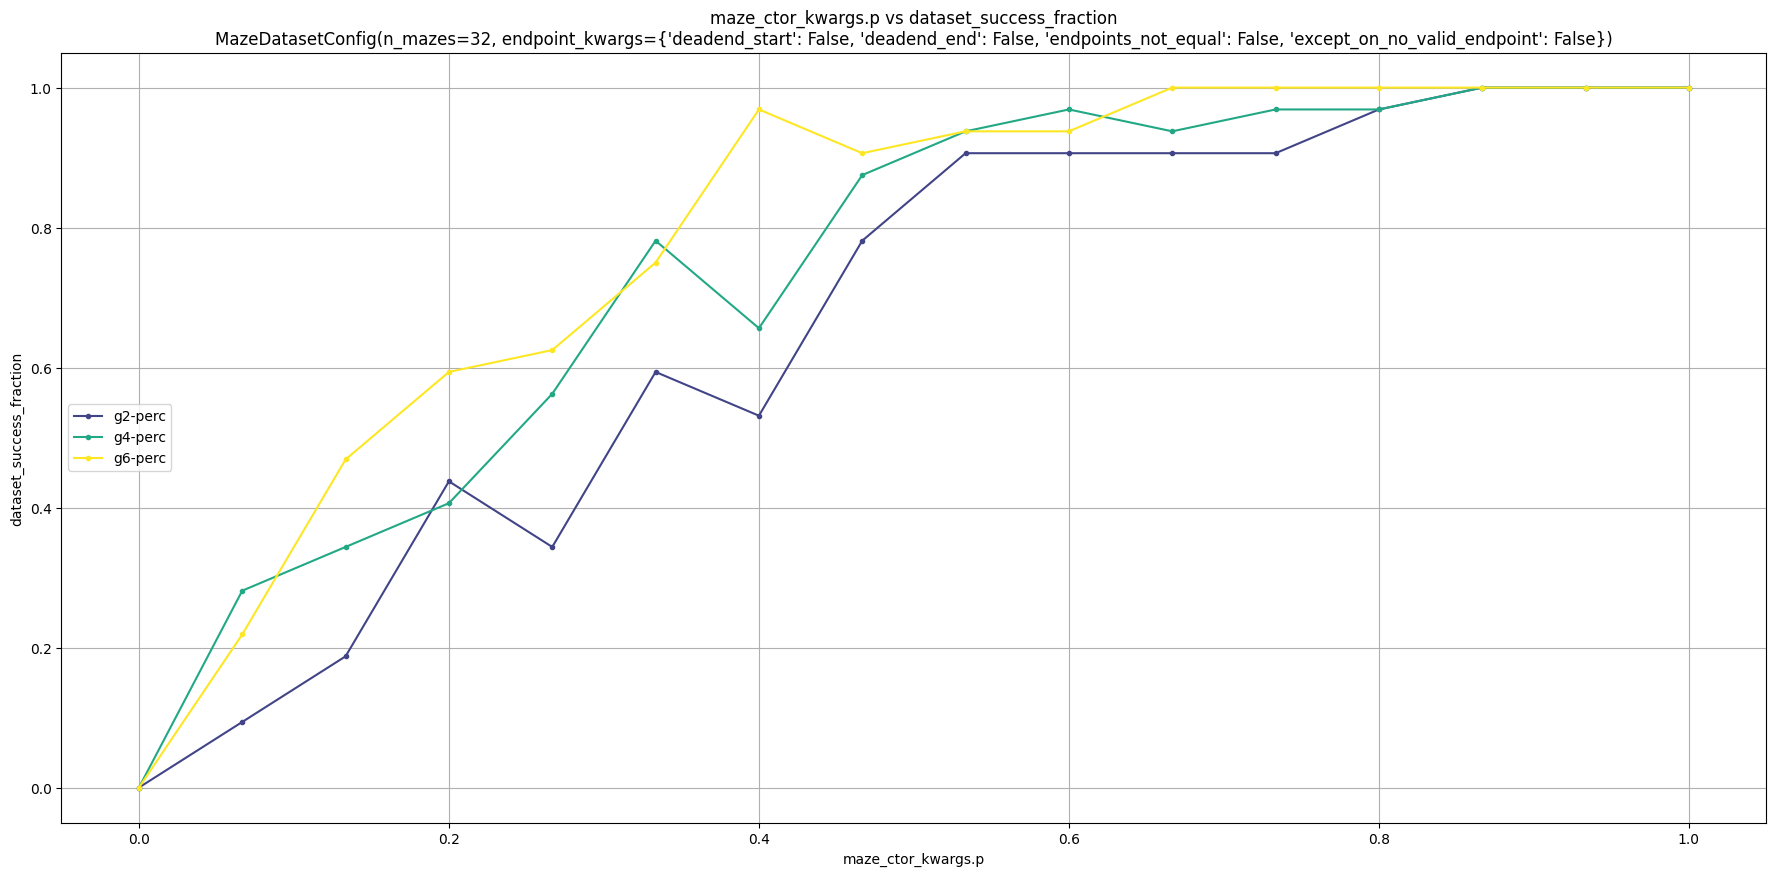

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=32,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'postfix', 'disable', 'write_bytes', 'ascii', 'desc', 'unit_divisor', 'smoothing', 'colour', 'file', 'leave', 'nrows', 'iterable', 'initial', 'mininterval', 'unit', 'maxinterval', 'bar_format', 'delay', 'total', 'self', 'gui', 'lock_args', 'position', 'unit_scale', 'miniters', 'dynamic_ncols', 'ncols'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:36<00:00,  2.01s/it]


Saving results to ../docs/benchmarks/percolation_fractions/result-n32-c18-p16.zanj


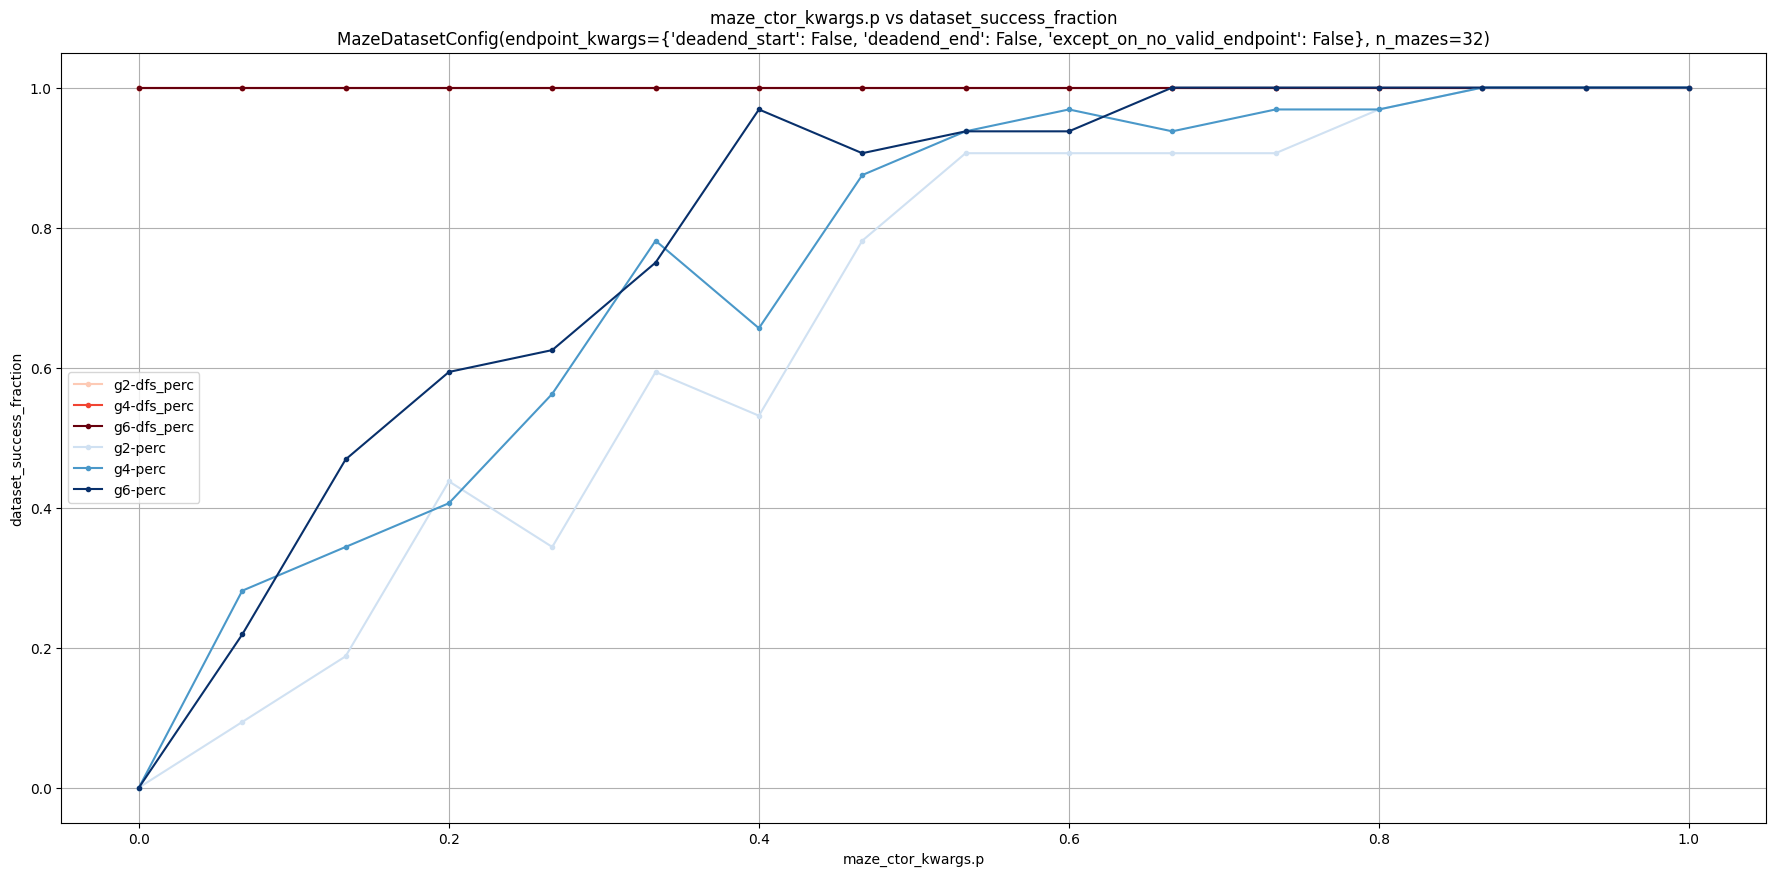

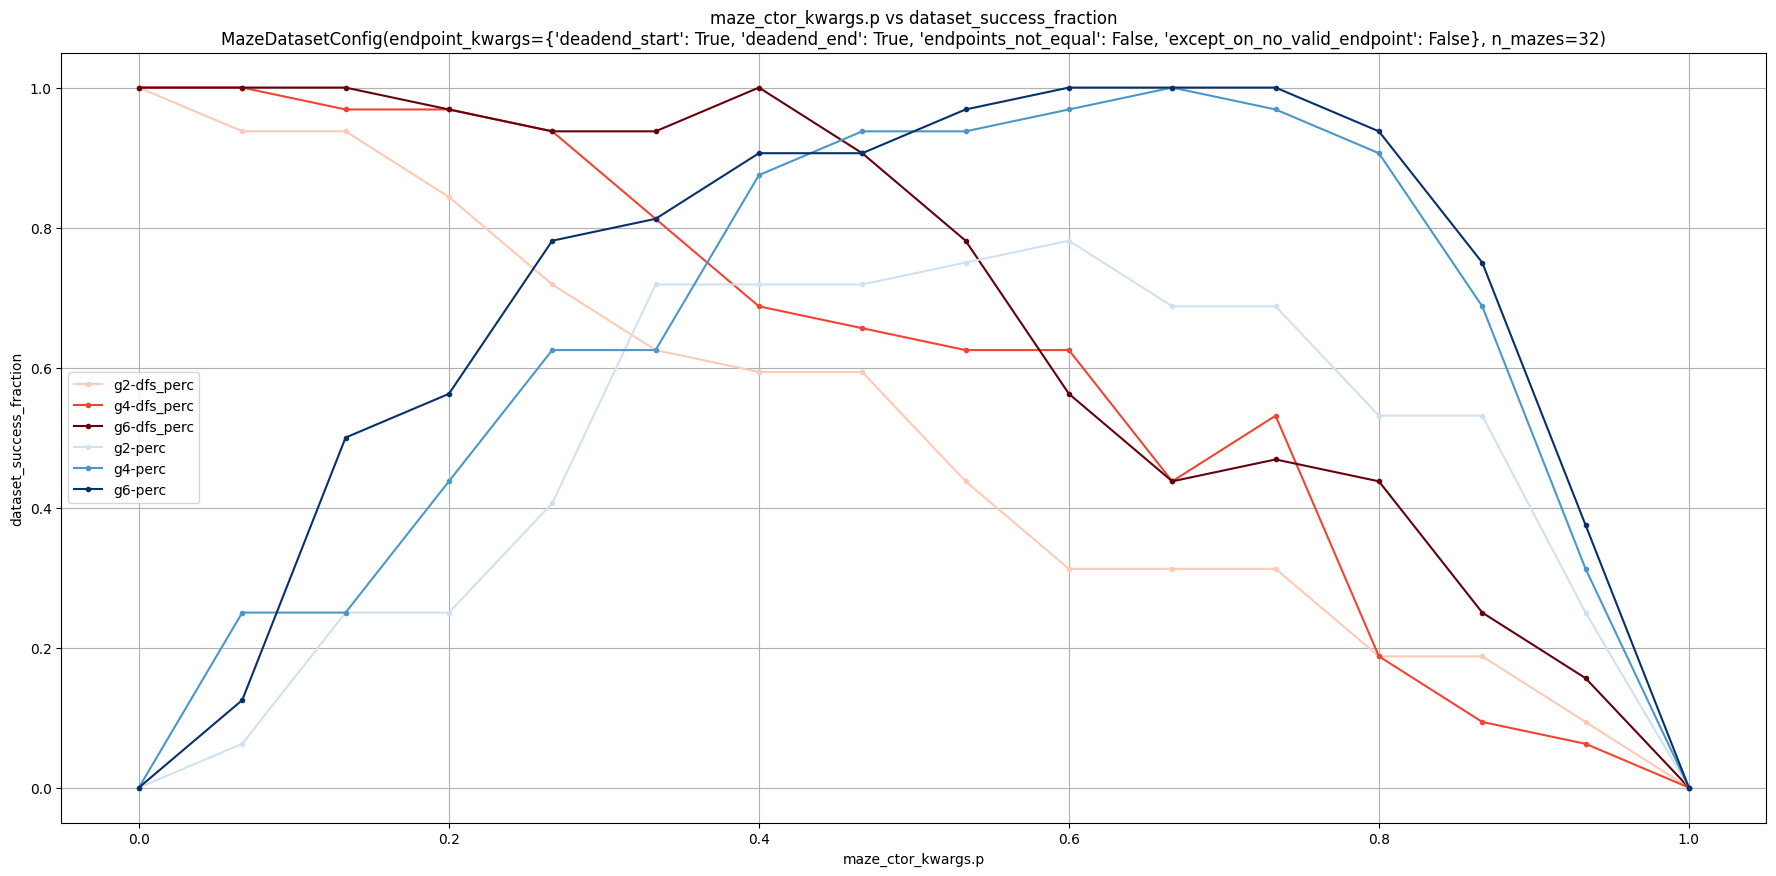

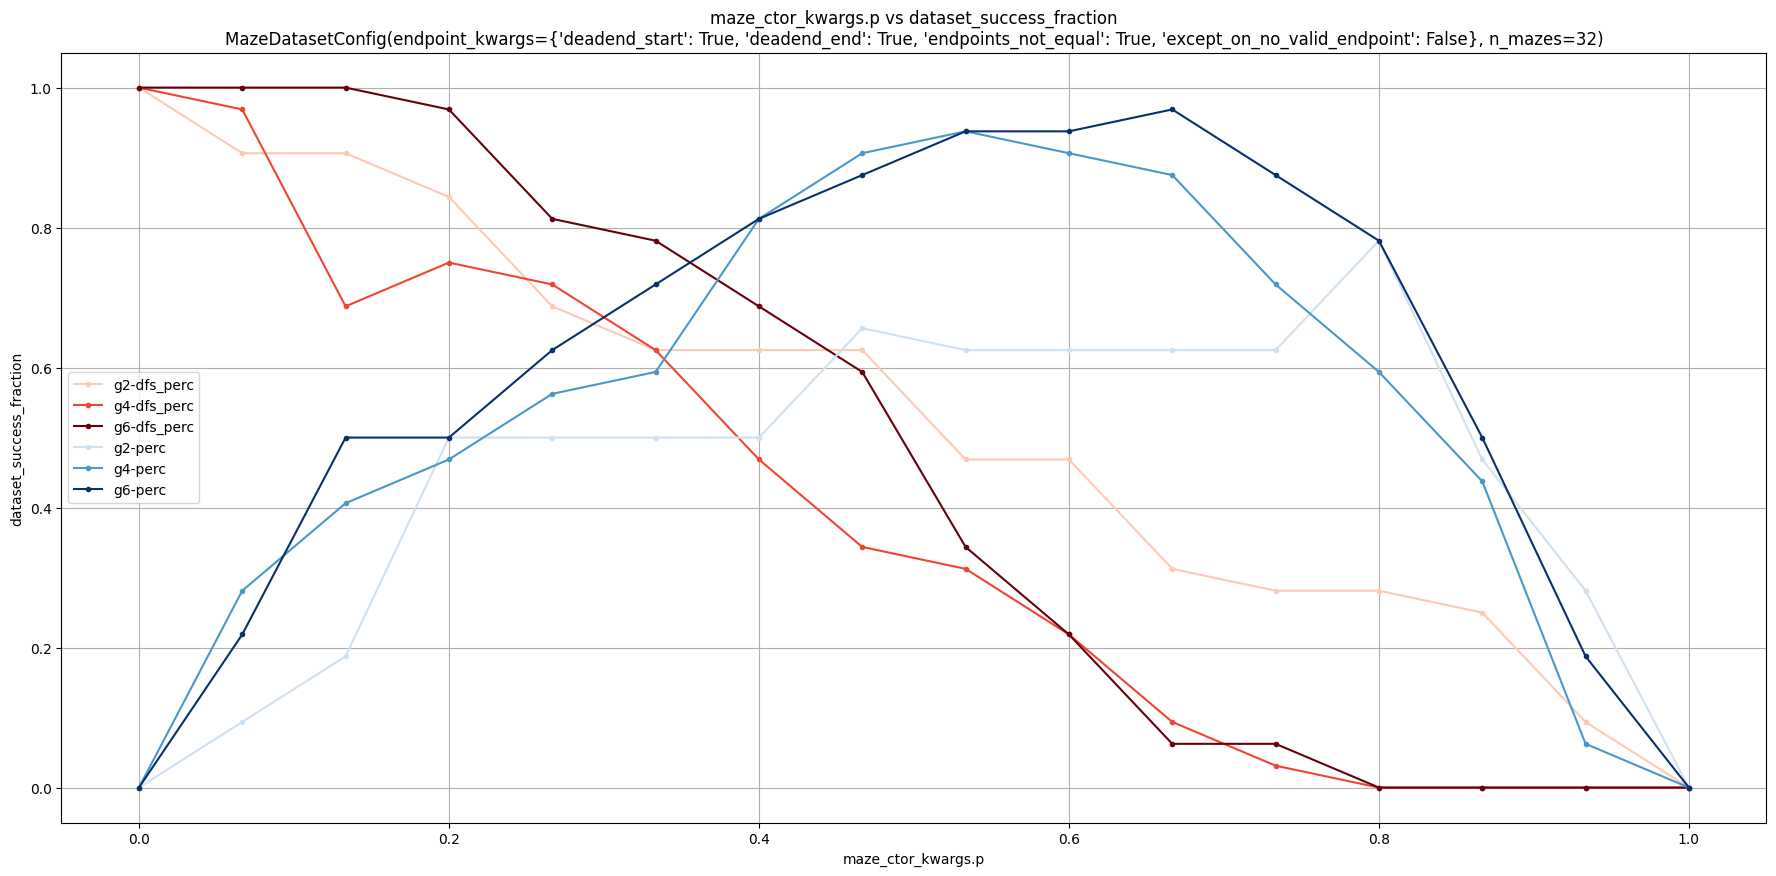

In [6]:
plot_grouped(results_full)

In [ ]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list: list[list[float]] = []
    y_list: list[float] = []
    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(sweep_result.param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    return np.array(X_list, dtype=np.float64), np.array(y_list, dtype=np.float64)


def main(sr: SweepResult, niterations: int = 200) -> None:
    # Convert to arrays
    X, y = extract_training_data(sr)

    # Fit the PySR model
    model = PySRRegressor(
        niterations=niterations,
        # Adjust operators as needed
        unary_operators=["sin", "cos", "exp"],
        binary_operators=["+", "-", "*", "/"],
        # If you want advanced features, specify them here:
        # e.g. select_k_features=4, population_size=1000, etc.
        progress=True,
        model_selection="best",
    )
    model.fit(X, y)

    # Create a callable that predicts from MazeDatasetConfig
    predict_fn = model.get_best()["lambda_format"]

    def predict_config(cfg: MazeDatasetConfig) -> float:
        arr = cfg.to_array()
        return float(predict_fn(*arr))  # pass the array as separate args

    # Example new config
    test_config = MazeDatasetConfig(
        name="some_test",
        grid_n=16,
        n_mazes=100,
        maze_ctor=LatticeMazeGenerators.gen_percolation,
        maze_ctor_kwargs={"p": 0.3},
        endpoint_kwargs={
            "deadend_start": True,
            "deadend_end": True,
            "endpoints_not_equal": True,
        },
    )
    predicted_rate = predict_config(test_config)
    print("Best PySR Equation:", model.get_best()["equation"])
    print("Predicted success rate for test_config:", predicted_rate)


main(results_full)

f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.530e+05
Progress: 859 / 9300 total iterations (9.237%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.228e-01  1.594e+01  y = 0.64587
2           1.062e-01  1.460e-01  y = cos(x₂)
3           1.002e-01  5.749e-02  y = sin(cos(x₂))
5           9.972e-02  2.559e-03  y = (x₂ * -0.32258) + 0.861
6           9.056e-02  9.636e-02  y = cos((x₀ + -0.60545) + x₂)
7           8.036e-02  1.194e-01  y = sin(sin(x₀ + (x₀ + x₄)))
8           4.537e-02  5.717e-01  y = sin((x₀ * (x₂ + 1.5406)) + x₄)
9           4.214e-02  7.377e-02  y = sin((x₀ * (x₂ + 1.7077)) + sin(x₄))
10          4.162e-02  1.262e-02  y = sin(((x₂ + 2.0789) * sin(x₀)) + sin(x₄))
11          3.962e-02  4.915e-02  y = sin(sin(x₄ + 0.1406) + ((x₂ + 1.591) * x₀))
12          2.764e-02  3.602

[ Info: Final population:
[ Info: Results saved to:


TypeError: eval() arg 1 must be a string, bytes or code object

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 4094-4095: unexpected end of data